# DemoGCN

In [1]:
import torch
from gcn.data import read_data_ml100k, split_data_ml100k, load_data_ml100k
ratings_df, num_users, num_items = read_data_ml100k("./data/ml-latest-small")
train_data, test_data = split_data_ml100k(ratings_df, num_users, 'seq-aware', test_ratio=0.1)
users_train, items_train, ratings_train, train_candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit"
) # train_candidates is a dict of {user: [items]}
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit"
) # test_candidates is a dict of {user: [items]}

In [2]:
import numpy as np
existence_matrix = np.zeros((num_users, num_items))
for line in ratings_df.itertuples():
    user_index, item_index = int(line[1] - 1), int(line[2] - 1)
    existence_matrix[user_index, item_index] = 1
A = torch.FloatTensor(existence_matrix)
D_r = torch.sum(A, axis=0) 
D_l = torch.sum(A, axis=1) 
D_r = torch.diag(D_r)
D_l = torch.diag(D_l)
D_r = torch.sqrt(torch.inverse(D_r))
D_l = torch.sqrt(torch.inverse(D_l))
A_norm = torch.matmul(torch.matmul(D_l, A), D_r)
A_norm.shape

torch.Size([610, 9724])

In [3]:
import random
class PRDataset(torch.utils.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

In [4]:
batch_size = 1024
trainset = PRDataset(users_train, items_train, train_candidates, num_items)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [5]:
from gcn.models import DemoGCN
from gcn.loss import BPRLoss
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = DemoGCN(num_users, num_items, n_factors, 3, A_norm.to(device))
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss_fn = BPRLoss()

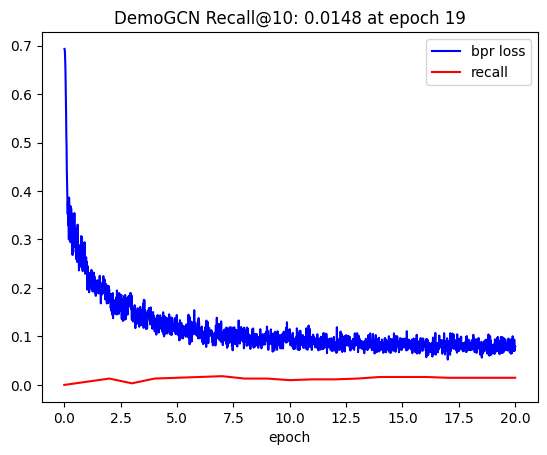

DemoGCN Recall@10: 0.0148 at epoch 19


In [6]:
from gcn.train import evaluate_ranking
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        input_data = []
        for v in values:
            input_data.append(v.to(device))

        p_pos = model(input_data[0], input_data[1])
        p_neg = model(input_data[0], input_data[-1])
        loss = loss_fn(p_pos, p_neg)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        epoch_list.append(epoch+1)


    scheduler.step()

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'DemoGCN Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'DemoGCN Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')

ani.close()

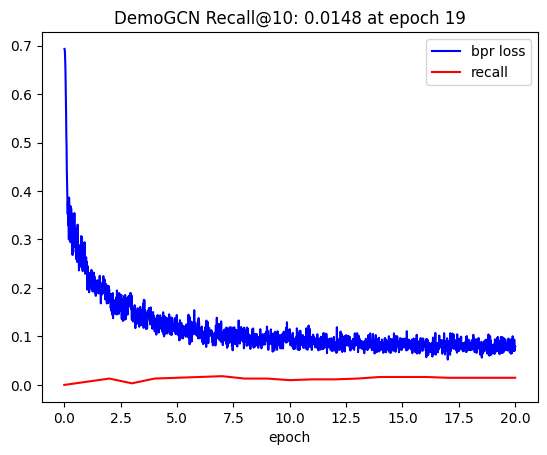

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.xlabel("epoch")
plt.legend()
plt.title(f'DemoGCN Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [8]:
max(recall_list)

0.018032786885245903